# GSMM
GSMM algorithm from literature.

## Load packages

In [32]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using LinearAlgebra
using PyPlot
using Compat
using WAV
using Base64
using DSP
using FFTW
using Distributions
using GaussianMixtures
using ProgressMeter
using BenchmarkTools

include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/preprocessing.jl")
;

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


## Set parameters

In [2]:
# signal preprocessing
sound_file1 = "../data/woman.wav"     # specify sound location
fs_desired = 8000                     # specify desired sampling frequency
normalization_method = "max"          # specify normalization method
μ = 255                               # specify parameter for μ-law companding and expansion
nr_freqs = 40                         # specify number of Fourier coefficients
pole_location = 0.4092                # specify pole location of warped filter bank (fs=8000: ~4092, fs=16000: ~0.5756)
step_size = 20                         # specify desired stepsize (currently trade-off between step size and distortion) TODO: ask Tanya, Bert or Joris
;

In [3]:
function preprocess(x::Array{Float64,1}, fs::Int64; fs_desired::Int64=8000, normalization_method::String="max")
    y = resample(x, fs_desired/fs)
    y = normalize(y, normalization_method)
    return y
end;

## Load and process signals

In [4]:
# load speech data
x_speech, fs_speech = wavread(sound_file1, format="native")
fs_speech = Int(fs_speech)
x_speech = convert(Array{Float64,1}, squeeze(x_speech[:,1]))[1*fs_speech:4*fs_speech]

# pre-process signals
y_speech = preprocess(x_speech, fs_speech)

# warp signal and take fft
f_speech = warp_fft(y_speech, pole_location, nr_freqs, step_size=step_size)

# reduce fft 
fr_speech = fft_reduce(f_speech)

# get the log abs values
z_speech = log.(abs2.(fr_speech))

# create audioplayers for signals
audioplayers(y_speech, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRkB3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQR3AQAXLxC+z7Zpvpv5Nb7BxRS+yVvfvUVPfL38sEc9gVMKPp4fZT6sOp8+RpLDPsjZwD5W47o+J/2cPmR09T0v+uG8ABMfvdIXpb07sH++OCiXvvv6Nb44zZu9eM6Yva0/Er1fmx09L+SrPe4cPj3Td6g79Y9svcGes72gmOG9KaAYvpjcUr7g8k++VXYXvuUq2b3Ba7S98BKWvE0V6z0WIGg+qiaSPtcnsj4xVMc+Y+TFPuDxqD69wBs+2NTxu1vSK71/F5i9vD17vvfDo77n4mO+8qS2vXTgrb10upW9vXA4PH9ivD1+8JY9nkMiPULRnrt0sj+9+GfJveM3A77Zhzq+DQNXvrM9OL6sCAi+sZXHvbpjMbzNJAw+UVOEPtSsoD7E7b8+lADZPjDuyz6qLmI+9XYmPSq+FjzI8Bi90mNgvt28t75p/Iu+A/EWvlMvCr6i3BS+HQoavQEv0D0Iq/89vKxwPfizijwG9Qs9jrqmPCbCrr3Z1zq+jNJEvjVxJL4keiC+3EEZvjBXnr2MpI49GgVMPhV4iz4g558+QLHGPmZX0j61LJs+IPC5Pav9lTn/17Q7GYnlvXvDpb5c6K6+oVxTvlTMHr71mze+1FzzveH14zuZzZg9n3yTPbNvHD2AEQ08FFl1PPSTUjyR6Kq94BgpvteY+r0ZPju9XzhLveXiVbvRpDA+MiaoPh8xsz4ljbg+wQigPhDOIj4g8aU9z/JTPUZa+r372qC+scqNvkacQL4qYV2++HlsvhJk0L1r9h49hYK2PZHD6z0FNvk9WjKdPVZphz1ds349YJgfvW9DQb4m1Ua+HMIFvp7XM75TKmy+RjEHvjgZTzxV2ng92D26PcCMOT4EqYI+i0mDPsGPVD6ugzA+nTT+Pd5ZkT3xbRC83llsvRsUeL2MM7K9Zi0lvnssI75Xrci9qmi8vUkO6b25a3+9WxlBPIrrMbp3VjG9LP9DvX5R6bw4Y8C8yXmxvHVINLt5PVw9ZmgYPgJFbz52tZA+wOSpPkjMvD4cb10+Vm88PAl83js3LbM8YPhIvo/NvL5g8nK+dWXcvZbBRL5zn12+/pvOvFIVBT4EjQA+pJjcPXo8Kz7HFUc+/HAiPkS9jD0YLKG8DyWqvVi5yL26PQi+6EhIvjMYSL690Oe9d5x2vfPRhb3/iQe93rIZPc3ImD1w7EI9tIwWPRM6Iz12ePo8nF+evDZ0Wr19ITy9syPvvG29Er15zyi9GHsOvY9/fLz0kdU7UhQJPK29SbuupwW79bNwPKqtezsR28C8Q+kXvUARabyojWC8mO+ovOtARztuQAE9O+oRPY3LIT1TEmI9vn2EPcHQgz3EujY99mz+PN5srjyxd388neOGvOCDPL1jlki9KPNLvaiFkr0oW6C9Ln1uvTsOVb1AKly951kvve3xuLxGoaq8Qf5avI9sMTqm8lU8kjemPCPtPz3CPog9JVyJPUujoj18Htg9md/QPdIjqj2p2nM9GmcyPcUijzz7qcK8CXCJvXfc273twPu9SAf9vdNDBr63pBO+BRbqvTnfoL1asH29sqw4vYkKU7yfsCY8TInsPATsOD2tXGA9K3CdPfjN+j19jx0+HJc2Pk8AST4o1Ds+PEj6PcNEoz1OXjE9YVF6vXRoFr6T7ya+3KYqvtU1Zb7x9m2+/j0qvj428r0Zzum9xu6fvX7Q07tXrfA89JYiPYvTgj1k0Mo9iFTtPf3jAj4mTCc+cPBTPtYIdj6udmU+htXiPdV63Dwge1M9vX+dPMapEr735k++J+/CvQP7yr1nqU++0uQkvl9bpLzLzSW82hRBvXOvBz2OiOY9xPysPeHRRz3ahps9njuJPdkRpbsLRiy9cQUIvVe1cr1lJMq934HHveZXrr21qKC9TDiGvUnZL71YbZq84zRIvNWEdrwBssm7wMkpPM4rejzys/m76LGTuz0cLTykokE675GBvJZF3zqYr4E7isl6vKC5mLzmlDK877QhvCFiBLzrGwe6r07jOw+O5TuOvjs8hukfPHiPyjzZqSc9jOQCPWK/kTygYcs8prkOPdttqjw/CpE8t4bXPGwJkTxap6Y6fBP7OREFTbvFfRa8XxkQvOODHryLh/a7pHUmvL8viLv2IGy6uT3bujm90juoq907o3DyOwS4qjx/f6E8uRUgPLAyxzzr6u08fnY0PIqvADzeMdU8HSPQPOZwLjwI0xA8sAVSOzILqTokr5Q8kIm7O6IDg7znR+I6RTyOPL3EVrrK1sK7JZYDPDQ/szrRZ7Y7AIsmPBIvLDtIeyE7jBFaPDsFgDwAARs7hH8RPMzaTDyuOTw8zlTBPF2iyLo6ZJE8tPL0PNly1DtaB6s8SWicPMMzlbt9/ms8v/nEPKj4t7sMHI68kXQfOylYF7wQM0S8jqePO/gdALyFJiO79ZswPACm2Lxa+Da82j4PPTaVJDyygB69V96ivIolHj2vutY7sk05va6Cgjyi37M8f8dDvao/ITxQohA9G/Y2vWzkG7087vA8ds8gvHZAQr26KMe8BatsOg8e1rzddmC8Z9CCvMRz77zPfvo7IMpiPB0xRb2nppq8vr/xPLrtm7y4cQO9cV1iO98/R7qi6Ka8G8mYvEQiyDua4ku8Ix3yvMQpU7xLgY27j9Z+vH5R9rxO21i8xhomvG8TZ7xzjhG8FGmnuzRCarpED0K7Piphu4HWE7vWSow7K2tVusQh+LvaO5m62L7Luia8LLosKQC89vnuuxNNsbuJ1mW7HxDcOpENmDrwfVe4H8NhO505vjtvWYq7umlcu/lLbLuzBRW8uSUyvJNWI7yYOge853JsvCCbcbzEExi8dieCu6qi/rqmyGa7amHZO4RmPzyjY+E7JtqRO9AZDTyP+NM7cx4kO2+gczs/Bqk6dB+yOZ95gToomHe6duJ8ul2fBLtO4IM5qREzO8exSLsmhMq7zkXQu2lzDLxGUwa80nASvEz5mLt5esG5IXlaOyU8qDvIF5S5t/+XO8gjFTylxNs7+IHMufnwGDtobfk7AQMcOzJSO7uFx3Y75hbiO3Wgfjvm6Ii6sF+SOzpfzDtW9v87eOkPPADrQjzBxjo819owPDZQOTwbKQY8BjQJPNf9CjzdWSo7tTmeOwf7yzsilA08p89APAge/jvKXPQ78RcLPC218jvtO9Q7+N7dO7FfPTxVjyM8TU6aO0H28zv+bxY8JLL2O1zUZjzSvH48ZMY1PJ4TETzei0A8wx/BO2GtgjuNAL47QZFhu90NubtkewK8cOGLu2ansbu81me7TgNhO5bEcDuRUjg61wsJO0ZtOjs/mCK6FAPBu2KV77vH1Cu8SXgivEy3TbwE/oe88OKTvF7TfbyEho+8oKyXvHYSUrxByne8n4aGvP3NirwysYK8B5mdvBpjp7wcYKO8sFe5vKGqrLxUgaq8/TygvG3eurwW+HG8vLFQvK58j7yxnl+8qD9bvMu4OLxnvYO8LF6jvEvuo7zclJ+8OtB+vK2Khbzr74G8D7R7vE80c7wNDI68VpiVvNH8dLyHfji8r5p/vEljY7yaeSO8jH4XvB9mILz6QYC7WDAFvBtELrykpfO7xXF9u0yikLvsYHK7A3zfu3nYPrtvjP43F5YGu1T9vTr3LmA6Xy8vOyoTaTtfRoo6rANJO+pBQzuGWLK7Gh0WusPwgzqXDfQ6mtKgOqpKgDtpneo70NaMO4hIyTslITU8UscMPGiMUDw313I8v+MoPDIvQzzHsAw8lpQ7PF8yGDxrCyM8mORJPLBP+Dufq/c7xpsjPJOQZDw86x48J6lAPCwxfjxhQDg8WXcQPC16VzwATHM8W3GKPEi8gjx/tHk8PXhuPLExmzxGg448aMlIPOf8QzyiX

## SGMM training

### Train GMM on log power domain for initialization

In [5]:
function trainGMM(clusters::Int64, y::Array{Float64,2}, kind::Symbol)
    if (kind == :full) & isposdef(y)
        g = GMM(clusters, y, kind=kind)
        p = GMMprior(g.d, 0.1, 1.0)  ## set α0=0.1 and β0=1, and other values to a default
        v = VGMM(g, p) ## initialize variational GMM v with g
        em!(v, y)
    elseif (kind == :full) & ~isposdef(y)
        println("data matrix not posdef, going for diagonal GMM")
        g = GMM(clusters, y, kind=:diag)
        em!(g, y)
    else
        g = GMM(clusters, y, nIter=50, nInit=100, kind=:diag)
        em!(g, y)
    end
    return g
end;

In [6]:
# train GMMs 
Ns = 20
g_speech = trainGMM(Ns, z_speech, :diag)

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       9.429380e+04
      1       5.399400e+04      -4.029980e+04 |       19
      2       5.026427e+04      -3.729729e+03 |       20
      3       4.892314e+04      -1.341132e+03 |       19
      4       4.850254e+04      -4.205940e+02 |       15
      5       4.831541e+04      -1.871357e+02 |       15
      6       4.825404e+04      -6.136622e+01 |        9
      7       4.822323e+04      -3.080872e+01 |       11
      8       4.817650e+04      -4.673497e+01 |       10
      9       4.814810e+04      -2.839288e+01 |       10
     10       4.811555e+04      -3.255112e+01 |        9
     11       4.809098e+04      -2.457173e+01 |        9
     12       4.807302e+04      -1.795630e+01 |        6
     13       4.805261e+04      -2.041336e+01 |        6
     14       4.802945e+04      -2.315817e+01 |        5
     15       4.797816e+04      -5.129367e+01 |        

┌ Info: Initializing GMM, 20 Gaussians diag covariance 21 dimensions using 1198 data points
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\bTNkf\src\train.jl:78



K-means converged with 26 iterations (objv = 47776.68276472937)


┌ Info: K-means with 1198 data points using 26 iterations
│ 2.7 data points per parameter
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\bTNkf\src\train.jl:139


GMM{Float64} with 20 components in 21 dimensions and diag covariance
⋮


### Function for SGMM EM algorithm

In [7]:
# initialize parameters
function initialize_parameters(g, z)
    
    # initialize μ
    μ = collect(g.μ')
    
    # initialize ν
    ν = 1 ./ g.Σ'
    
    # initialize ps
    ps = g.w
    
    # initialize ξ
    ξ = repeat(transpose(z), outer=[1,1,g.n])

    # initialize ϕ
    ϕ = ones(g.d, g.nx, g.n)
    
    # initialize f
    f = Array{Float64, 3}(undef, g.d, g.nx, g.n)
    
    # initialize qs
    qs = ones(g.nx, g.n) / g.n
    
    return ξ, ϕ, f, qs, μ, ν, ps
    
end
ξ, ϕ, f, qs, μ, ν, ps = initialize_parameters(g_speech, z_speech);

In [8]:
function update_ξ(ξ::Array{Float64,3}, ϕ::Array{Float64,3}, X::Array{Complex{Float64},2}, ν::Array{Float64,2}, μ::Array{Float64,2})::Array{Float64,3}
    for k = 1:size(ξ,1)
        for t = 1:size(ξ,2)
            for s = 1:size(ξ,3)
                @inbounds ξ[k,t,s] = ξ[k,t,s] + 1/ϕ[k,t,s]*( exp(-ξ[k,t,s])*abs2(X[k,t]) - ν[k,s]*ξ[k,t,s] + ν[k,s]*μ[k,s] - 1 ) 
            end
        end
    end
    return ξ
end

update_ξ (generic function with 1 method)

In [9]:
function update_ϕ(ϕ::Array{Float64,3}, ξ::Array{Float64,3}, X::Array{Complex{Float64},2}, ν::Array{Float64,2})::Array{Float64,3}
    for k = 1:size(ξ,1)
        for t = 1:size(ξ,2)
            for s = 1:size(ξ,3)
                @inbounds ϕ[k,t,s] = exp(-ξ[k,t,s])*abs2(X[k,t]) + ν[k,s]
            end
        end
    end
    return ϕ
end

update_ϕ (generic function with 1 method)

In [10]:
function update_f(f::Array{Float64,3}, ξ::Array{Float64,3}, ϕ::Array{Float64,3}, X::Array{Complex{Float64},2}, ν::Array{Float64,2}, μ::Array{Float64,2})::Array{Float64,3}
    for k = 1:size(ξ,1)
        for t = 1:size(ξ,2)
            for s = 1:size(ξ,3)
                @inbounds f[k,t,s] = 0.5*log(ν[k,s]) - log(pi) - 0.5*log(ϕ[k,t,s]) - exp(-ξ[k,t,s] + 1/(2*ϕ[k,t,s])) * abs2(X[k,t]) - ξ[k,t,s] - ν[k,s]/2*(1/ϕ[k,t,s] + (ξ[k,t,s] - μ[k,s])^2) + 0.5
            end
        end
    end
    return f
end

update_f (generic function with 1 method)

In [11]:
function update_qs(qs::Array{Float64,2}, ps::Array{Float64,1}, f::Array{Float64,3})
    F = 0.0
    for t = 1:size(f,2)
        for s = 1:size(f,3)
            @inbounds qs[t,s] = exp(sum(f[:,t,s]))*ps[s]
        end
        Zt = sum(qs[t,:])
        qs[t,:] = qs[t,:] / Zt
        F = F + log(Zt)
    end
    return qs, F
end

update_qs (generic function with 1 method)

In [12]:
function update_μ(μ::Array{Float64,2}, qs::Array{Float64,2}, ξ::Array{Float64,3})
    for k = 1:size(ξ, 1)
        for s = 1:size(ξ, 3)
            @inbounds μ[k,s] = sum(qs[:,s].*ξ[k,:,s])/sum(qs[:,s])
        end
    end
    return μ
end

update_μ (generic function with 1 method)

In [13]:
function update_ν(ν::Array{Float64,2}, qs::Array{Float64,2}, μ::Array{Float64,2}, ξ::Array{Float64,3}, ϕ::Array{Float64,3})
    for k = 1:size(ξ, 1)
        for s = 1:size(ξ, 3)
            @inbounds ν[k,s] = sum(qs[:,s])/sum(qs[:,s] .* ((ξ[k,:,s] .- μ[k,s]).^2 + 1 ./ ϕ[k,:,s]))
        end
    end
    return ν
end

update_ν (generic function with 1 method)

In [14]:
function update_ps(qs::Array{Float64,2})
    return squeeze(sum(qs, dims=1)) / sum(qs)
end

update_ps (generic function with 1 method)

In [15]:
function Estep(X::Array{Complex{Float64},2}, ξ::Array{Float64,3}, ϕ::Array{Float64,3}, ν::Array{Float64,2}, μ::Array{Float64,2}, f::Array{Float64,3}, qs::Array{Float64,2}, ps::Array{Float64,1})
    
    ξ = update_ξ(ξ, ϕ, X, ν, μ)
    ϕ = update_ϕ(ϕ, ξ, X, ν)
    f = update_f(f, ξ, ϕ, X, ν, μ)
    qs, F = update_qs(qs, ps, f)
    return ξ, ϕ, f, qs, F
end

Estep (generic function with 1 method)

In [16]:
function Mstep(μ::Array{Float64,2}, ν::Array{Float64,2}, qs::Array{Float64,2}, ξ::Array{Float64,3}, ϕ::Array{Float64,3})
    μ = update_μ(μ, qs, ξ)
    ν = update_ν(ν, qs, μ, ξ, ϕ) 
    ps = update_ps(qs)
    return μ, ν, ps
end

Mstep (generic function with 1 method)

## Train SGMM

In [17]:
ξ, ϕ, f, qs, μ, ν, ps = initialize_parameters(g_speech, z_speech)
Fmem = Float64[]
# specify data
X = collect(transpose(fr_speech))
for _=1:100
    ξ, ϕ, f, qs, F = Estep(X, ξ, ϕ, ν, μ, f, qs, ps)
    push!(Fmem, F)
    μ, ν, ps = Mstep(μ, ν, qs, ξ, ϕ)
end
;

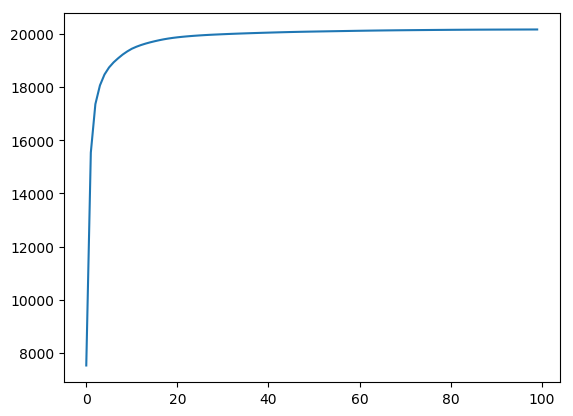

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000026B2E10>

In [18]:
plt.plot(Fmem)

## Variational Bayesian Inference

### Functions

In [19]:
function VB_initialize(Y::Array{Complex{Float64},1}, γ::Array{Float64,1}, ν::Array{Float64,2}, g)
    
    # Initialize ξ
    ξ::Array{Float64,2} = repeat(log.(abs2.(Y)), outer=[1, g.n])
    
    # Initialize ϕ
    ϕ = Array{Float64,2}(undef, g.d, g.n)
    for k = 1:g.d
        for s = 1:g.n
            ϕ[k,s] = γ[k] + exp(-ξ[k,s])
        end
    end
    
    # Initialize X
    X = Array{Complex{Float64},2}(undef, g.d, g.n)
    for k = 1:g.d
        for s = 1:g.n
            X[k,s] = γ[k] / ϕ[k,s] * Y[k]
        end
    end
        
    # Initialize ψ
    ψ = exp.(-ξ) .* (abs2.(X) + 1 ./ ϕ) + ν
    
    return ξ, ϕ, X, ψ
end

VB_initialize (generic function with 1 method)

In [20]:
function VB_update_qX(X::Array{Complex{Float64},2}, ϕ::Array{Float64,2}, Y::Array{Complex{Float64},1}, γ::Array{Float64,1}, ξ::Array{Float64,2}, ψ::Array{Float64,2})
    for k = 1:size(X,1)
        for s = 1:size(X,2)
            @inbounds ϕ[k,s] = γ[k] + exp(-ξ[k,s] + 1/2/ψ[k,s])
            @inbounds X[k,s] = γ[k]/ϕ[k,s]*Y[k]
        end
    end
    return X, ϕ
end

VB_update_qX (generic function with 1 method)

In [21]:
function VB_update_qξ(ξ::Array{Float64,2}, ψ::Array{Float64,2}, X::Array{Complex{Float64},2}, ϕ::Array{Float64,2}, ν::Array{Float64,2}, μ::Array{Float64,2})
    for k = 1:size(X,1)
        for s = 1:size(X,2)
            @inbounds ψ[k,s] = exp(-ξ[k,s])*(abs2(X[k,s]) + 1/ϕ[k,s]) + ν[k,s]
            @inbounds ξ[k,s] = ξ[k,s] + 1/ψ[k,s]*(exp(-ξ[k,s])*(abs2(X[k,s]) + 1/ϕ[k,s]) - ν[k,s]*(ξ[k,s] - μ[k,s]) - 1)
        end
    end
    return ξ, ψ
end

VB_update_qξ (generic function with 1 method)

In [22]:
function VB_posterior_mixture(Y::Array{Complex{Float64},1}, X::Array{Complex{Float64},2}, γ::Array{Float64,1}, ξ::Array{Float64,2}, ψ::Array{Float64,2}, ϕ::Array{Float64,2}, ν::Array{Float64,2}, μ::Array{Float64,2}, ps::Array{Float64,1})
    g = Array{Float64,2}(undef, size(X))
    for k = 1:size(X,1)
        for s = 1:size(X,2)
            @inbounds g[k,s] = log(γ[k]*sqrt(ν[k,s])/pi/ϕ[k,s]/sqrt(ψ[k,s])) - γ[k]*abs2(X[k,s]) + ϕ[k,s]*abs2(X[k,s])  - ξ[k,s] - ν[k,s]/2*((ξ[k,s] - μ[k,s])^2 + 1/ψ[k,s]) + 0.5
        end
    end
    Z::Float64 = sum(exp.(squeeze(sum(g, dims=1))).*ps)
    qs::Array{Float64,1} = exp.(squeeze(sum(g, dims=1))).*ps/Z
    return qs, log(Z)
end

VB_posterior_mixture (generic function with 1 method)

In [23]:
function VB_predict(Y::Array{Complex{Float64},1}, X::Array{Complex{Float64},2}, ξ::Array{Float64,2}, qs::Array{Float64,1})
    return X*qs, exp.(ξ*qs/2) .* exp.(1im*angle.(Y))
end

VB_predict (generic function with 1 method)

In [24]:
function VB_process_frame(Y, g, γ, μ, ν, ps, iterations)
    ξ, ϕ, X, ψ = VB_initialize(Y, γ, ν, g)
    qs = Array{Float64,1}(undef, g.n)
    for _ = 1:20
        ξ, ψ = VB_update_qξ(ξ, ψ, X, ϕ, ν, μ)
        X, ϕ = VB_update_qX(X, ϕ, Y, γ, ξ, ψ)
        qs, _ = VB_posterior_mixture(Y, X, γ, ξ, ψ, ϕ, ν, μ, ps)
    end
    return VB_predict(Y, X, ξ, qs)
end

VB_process_frame (generic function with 1 method)

In [39]:
f_pred1 = Array{Complex{Float64},2}(undef, size(fr_speech))
f_pred2 = Array{Complex{Float64},2}(undef, size(fr_speech))

γ = 10000*ones(g_speech.d)
for k = 1:size(fr_speech,1)
    f_pred1[k,:], f_pred2[k,:] = VB_process_frame(fr_speech[k,:], g_speech, γ, μ, ν, ps, 20)
end

f_pred1 = fft_expand(f_pred1)
f_pred2 = fft_expand(f_pred2)

y_pred1 = warp_ifft(f_pred1, pole_location, step_size)
y_pred2 = warp_ifft(f_pred2, pole_location, step_size)
;

### Predictions based on frequency coefficients

<source src="data:audio/wav;base64,UklGRkB3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQR3AQAXLxC+z7Zpvpv5Nb7BxRS+yVvfvUVPfL38sEc9gVMKPp4fZT6sOp8+RpLDPsjZwD5W47o+J/2cPmR09T0v+uG8ABMfvdIXpb07sH++OCiXvvv6Nb44zZu9eM6Yva0/Er1fmx09L+SrPe4cPj3Td6g79Y9svcGes72gmOG9KaAYvpjcUr7g8k++VXYXvuUq2b3Ba7S98BKWvE0V6z0WIGg+qiaSPtcnsj4xVMc+Y+TFPuDxqD69wBs+2NTxu1vSK71/F5i9vD17vvfDo77n4mO+8qS2vXTgrb10upW9vXA4PH9ivD1+8JY9nkMiPULRnrt0sj+9+GfJveM3A77Zhzq+DQNXvrM9OL6sCAi+sZXHvbpjMbzNJAw+UVOEPtSsoD7E7b8+lADZPjDuyz6qLmI+9XYmPSq+FjzI8Bi90mNgvt28t75p/Iu+A/EWvlMvCr6i3BS+HQoavQEv0D0Iq/89vKxwPfizijwG9Qs9jrqmPCbCrr3Z1zq+jNJEvjVxJL4keiC+3EEZvjBXnr2MpI49GgVMPhV4iz4g558+QLHGPmZX0j61LJs+IPC5Pav9lTn/17Q7GYnlvXvDpb5c6K6+oVxTvlTMHr71mze+1FzzveH14zuZzZg9n3yTPbNvHD2AEQ08FFl1PPSTUjyR6Kq94BgpvteY+r0ZPju9XzhLveXiVbvRpDA+MiaoPh8xsz4ljbg+wQigPhDOIj4g8aU9z/JTPUZa+r372qC+scqNvkacQL4qYV2++HlsvhJk0L1r9h49hYK2PZHD6z0FNvk9WjKdPVZphz1ds349YJgfvW9DQb4m1Ua+HMIFvp7XM75TKmy+RjEHvjgZTzxV2ng92D26PcCMOT4EqYI+i0mDPsGPVD6ugzA+nTT+Pd5ZkT3xbRC83llsvRsUeL2MM7K9Zi0lvnssI75Xrci9qmi8vUkO6b25a3+9WxlBPIrrMbp3VjG9LP9DvX5R6bw4Y8C8yXmxvHVINLt5PVw9ZmgYPgJFbz52tZA+wOSpPkjMvD4cb10+Vm88PAl83js3LbM8YPhIvo/NvL5g8nK+dWXcvZbBRL5zn12+/pvOvFIVBT4EjQA+pJjcPXo8Kz7HFUc+/HAiPkS9jD0YLKG8DyWqvVi5yL26PQi+6EhIvjMYSL690Oe9d5x2vfPRhb3/iQe93rIZPc3ImD1w7EI9tIwWPRM6Iz12ePo8nF+evDZ0Wr19ITy9syPvvG29Er15zyi9GHsOvY9/fLz0kdU7UhQJPK29SbuupwW79bNwPKqtezsR28C8Q+kXvUARabyojWC8mO+ovOtARztuQAE9O+oRPY3LIT1TEmI9vn2EPcHQgz3EujY99mz+PN5srjyxd388neOGvOCDPL1jlki9KPNLvaiFkr0oW6C9Ln1uvTsOVb1AKly951kvve3xuLxGoaq8Qf5avI9sMTqm8lU8kjemPCPtPz3CPog9JVyJPUujoj18Htg9md/QPdIjqj2p2nM9GmcyPcUijzz7qcK8CXCJvXfc273twPu9SAf9vdNDBr63pBO+BRbqvTnfoL1asH29sqw4vYkKU7yfsCY8TInsPATsOD2tXGA9K3CdPfjN+j19jx0+HJc2Pk8AST4o1Ds+PEj6PcNEoz1OXjE9YVF6vXRoFr6T7ya+3KYqvtU1Zb7x9m2+/j0qvj428r0Zzum9xu6fvX7Q07tXrfA89JYiPYvTgj1k0Mo9iFTtPf3jAj4mTCc+cPBTPtYIdj6udmU+htXiPdV63Dwge1M9vX+dPMapEr735k++J+/CvQP7yr1nqU++0uQkvl9bpLzLzSW82hRBvXOvBz2OiOY9xPysPeHRRz3ahps9njuJPdkRpbsLRiy9cQUIvVe1cr1lJMq934HHveZXrr21qKC9TDiGvUnZL71YbZq84zRIvNWEdrwBssm7wMkpPM4rejzys/m76LGTuz0cLTykokE675GBvJZF3zqYr4E7isl6vKC5mLzmlDK877QhvCFiBLzrGwe6r07jOw+O5TuOvjs8hukfPHiPyjzZqSc9jOQCPWK/kTygYcs8prkOPdttqjw/CpE8t4bXPGwJkTxap6Y6fBP7OREFTbvFfRa8XxkQvOODHryLh/a7pHUmvL8viLv2IGy6uT3bujm90juoq907o3DyOwS4qjx/f6E8uRUgPLAyxzzr6u08fnY0PIqvADzeMdU8HSPQPOZwLjwI0xA8sAVSOzILqTokr5Q8kIm7O6IDg7znR+I6RTyOPL3EVrrK1sK7JZYDPDQ/szrRZ7Y7AIsmPBIvLDtIeyE7jBFaPDsFgDwAARs7hH8RPMzaTDyuOTw8zlTBPF2iyLo6ZJE8tPL0PNly1DtaB6s8SWicPMMzlbt9/ms8v/nEPKj4t7sMHI68kXQfOylYF7wQM0S8jqePO/gdALyFJiO79ZswPACm2Lxa+Da82j4PPTaVJDyygB69V96ivIolHj2vutY7sk05va6Cgjyi37M8f8dDvao/ITxQohA9G/Y2vWzkG7087vA8ds8gvHZAQr26KMe8BatsOg8e1rzddmC8Z9CCvMRz77zPfvo7IMpiPB0xRb2nppq8vr/xPLrtm7y4cQO9cV1iO98/R7qi6Ka8G8mYvEQiyDua4ku8Ix3yvMQpU7xLgY27j9Z+vH5R9rxO21i8xhomvG8TZ7xzjhG8FGmnuzRCarpED0K7Piphu4HWE7vWSow7K2tVusQh+LvaO5m62L7Luia8LLosKQC89vnuuxNNsbuJ1mW7HxDcOpENmDrwfVe4H8NhO505vjtvWYq7umlcu/lLbLuzBRW8uSUyvJNWI7yYOge853JsvCCbcbzEExi8dieCu6qi/rqmyGa7amHZO4RmPzyjY+E7JtqRO9AZDTyP+NM7cx4kO2+gczs/Bqk6dB+yOZ95gToomHe6duJ8ul2fBLtO4IM5qREzO8exSLsmhMq7zkXQu2lzDLxGUwa80nASvEz5mLt5esG5IXlaOyU8qDvIF5S5t/+XO8gjFTylxNs7+IHMufnwGDtobfk7AQMcOzJSO7uFx3Y75hbiO3Wgfjvm6Ii6sF+SOzpfzDtW9v87eOkPPADrQjzBxjo819owPDZQOTwbKQY8BjQJPNf9CjzdWSo7tTmeOwf7yzsilA08p89APAge/jvKXPQ78RcLPC218jvtO9Q7+N7dO7FfPTxVjyM8TU6aO0H28zv+bxY8JLL2O1zUZjzSvH48ZMY1PJ4TETzei0A8wx/BO2GtgjuNAL47QZFhu90NubtkewK8cOGLu2ansbu81me7TgNhO5bEcDuRUjg61wsJO0ZtOjs/mCK6FAPBu2KV77vH1Cu8SXgivEy3TbwE/oe88OKTvF7TfbyEho+8oKyXvHYSUrxByne8n4aGvP3NirwysYK8B5mdvBpjp7wcYKO8sFe5vKGqrLxUgaq8/TygvG3eurwW+HG8vLFQvK58j7yxnl+8qD9bvMu4OLxnvYO8LF6jvEvuo7zclJ+8OtB+vK2Khbzr74G8D7R7vE80c7wNDI68VpiVvNH8dLyHfji8r5p/vEljY7yaeSO8jH4XvB9mILz6QYC7WDAFvBtELrykpfO7xXF9u0yikLvsYHK7A3zfu3nYPrtvjP43F5YGu1T9vTr3LmA6Xy8vOyoTaTtfRoo6rANJO+pBQzuGWLK7Gh0WusPwgzqXDfQ6mtKgOqpKgDtpneo70NaMO4hIyTslITU8UscMPGiMUDw313I8v+MoPDIvQzzHsAw8lpQ7PF8yGDxrCyM8mORJPLBP+Dufq/c7xpsjPJOQZDw86x48J6lAPCwxfjxhQDg8WXcQPC16VzwATHM8W3GKPEi8gjx/tHk8PXhuPLExmzxGg448aMlIPOf8QzyiX

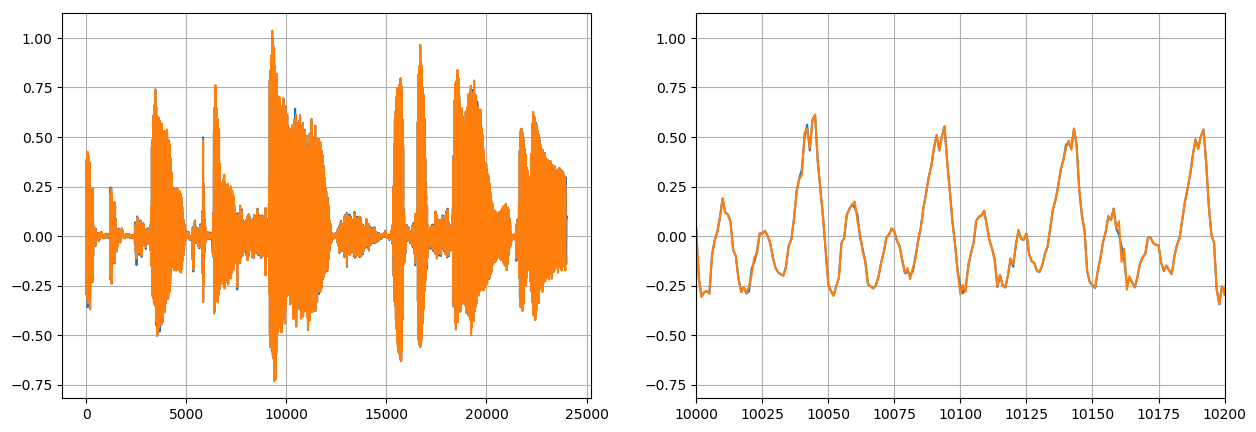

In [40]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(y_speech)
ax[1].plot(y_pred1)
ax[2].plot(y_speech)
ax[2].plot(y_pred1)
ax[1].grid(), ax[2].grid(), ax[2].set_xlim([10000, 10200])
audioplayers(y_speech, y_pred1, fs=fs_desired)

### Predictions based on log-spectrum

<source src="data:audio/wav;base64,UklGRkB3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQR3AQAXLxC+z7Zpvpv5Nb7BxRS+yVvfvUVPfL38sEc9gVMKPp4fZT6sOp8+RpLDPsjZwD5W47o+J/2cPmR09T0v+uG8ABMfvdIXpb07sH++OCiXvvv6Nb44zZu9eM6Yva0/Er1fmx09L+SrPe4cPj3Td6g79Y9svcGes72gmOG9KaAYvpjcUr7g8k++VXYXvuUq2b3Ba7S98BKWvE0V6z0WIGg+qiaSPtcnsj4xVMc+Y+TFPuDxqD69wBs+2NTxu1vSK71/F5i9vD17vvfDo77n4mO+8qS2vXTgrb10upW9vXA4PH9ivD1+8JY9nkMiPULRnrt0sj+9+GfJveM3A77Zhzq+DQNXvrM9OL6sCAi+sZXHvbpjMbzNJAw+UVOEPtSsoD7E7b8+lADZPjDuyz6qLmI+9XYmPSq+FjzI8Bi90mNgvt28t75p/Iu+A/EWvlMvCr6i3BS+HQoavQEv0D0Iq/89vKxwPfizijwG9Qs9jrqmPCbCrr3Z1zq+jNJEvjVxJL4keiC+3EEZvjBXnr2MpI49GgVMPhV4iz4g558+QLHGPmZX0j61LJs+IPC5Pav9lTn/17Q7GYnlvXvDpb5c6K6+oVxTvlTMHr71mze+1FzzveH14zuZzZg9n3yTPbNvHD2AEQ08FFl1PPSTUjyR6Kq94BgpvteY+r0ZPju9XzhLveXiVbvRpDA+MiaoPh8xsz4ljbg+wQigPhDOIj4g8aU9z/JTPUZa+r372qC+scqNvkacQL4qYV2++HlsvhJk0L1r9h49hYK2PZHD6z0FNvk9WjKdPVZphz1ds349YJgfvW9DQb4m1Ua+HMIFvp7XM75TKmy+RjEHvjgZTzxV2ng92D26PcCMOT4EqYI+i0mDPsGPVD6ugzA+nTT+Pd5ZkT3xbRC83llsvRsUeL2MM7K9Zi0lvnssI75Xrci9qmi8vUkO6b25a3+9WxlBPIrrMbp3VjG9LP9DvX5R6bw4Y8C8yXmxvHVINLt5PVw9ZmgYPgJFbz52tZA+wOSpPkjMvD4cb10+Vm88PAl83js3LbM8YPhIvo/NvL5g8nK+dWXcvZbBRL5zn12+/pvOvFIVBT4EjQA+pJjcPXo8Kz7HFUc+/HAiPkS9jD0YLKG8DyWqvVi5yL26PQi+6EhIvjMYSL690Oe9d5x2vfPRhb3/iQe93rIZPc3ImD1w7EI9tIwWPRM6Iz12ePo8nF+evDZ0Wr19ITy9syPvvG29Er15zyi9GHsOvY9/fLz0kdU7UhQJPK29SbuupwW79bNwPKqtezsR28C8Q+kXvUARabyojWC8mO+ovOtARztuQAE9O+oRPY3LIT1TEmI9vn2EPcHQgz3EujY99mz+PN5srjyxd388neOGvOCDPL1jlki9KPNLvaiFkr0oW6C9Ln1uvTsOVb1AKly951kvve3xuLxGoaq8Qf5avI9sMTqm8lU8kjemPCPtPz3CPog9JVyJPUujoj18Htg9md/QPdIjqj2p2nM9GmcyPcUijzz7qcK8CXCJvXfc273twPu9SAf9vdNDBr63pBO+BRbqvTnfoL1asH29sqw4vYkKU7yfsCY8TInsPATsOD2tXGA9K3CdPfjN+j19jx0+HJc2Pk8AST4o1Ds+PEj6PcNEoz1OXjE9YVF6vXRoFr6T7ya+3KYqvtU1Zb7x9m2+/j0qvj428r0Zzum9xu6fvX7Q07tXrfA89JYiPYvTgj1k0Mo9iFTtPf3jAj4mTCc+cPBTPtYIdj6udmU+htXiPdV63Dwge1M9vX+dPMapEr735k++J+/CvQP7yr1nqU++0uQkvl9bpLzLzSW82hRBvXOvBz2OiOY9xPysPeHRRz3ahps9njuJPdkRpbsLRiy9cQUIvVe1cr1lJMq934HHveZXrr21qKC9TDiGvUnZL71YbZq84zRIvNWEdrwBssm7wMkpPM4rejzys/m76LGTuz0cLTykokE675GBvJZF3zqYr4E7isl6vKC5mLzmlDK877QhvCFiBLzrGwe6r07jOw+O5TuOvjs8hukfPHiPyjzZqSc9jOQCPWK/kTygYcs8prkOPdttqjw/CpE8t4bXPGwJkTxap6Y6fBP7OREFTbvFfRa8XxkQvOODHryLh/a7pHUmvL8viLv2IGy6uT3bujm90juoq907o3DyOwS4qjx/f6E8uRUgPLAyxzzr6u08fnY0PIqvADzeMdU8HSPQPOZwLjwI0xA8sAVSOzILqTokr5Q8kIm7O6IDg7znR+I6RTyOPL3EVrrK1sK7JZYDPDQ/szrRZ7Y7AIsmPBIvLDtIeyE7jBFaPDsFgDwAARs7hH8RPMzaTDyuOTw8zlTBPF2iyLo6ZJE8tPL0PNly1DtaB6s8SWicPMMzlbt9/ms8v/nEPKj4t7sMHI68kXQfOylYF7wQM0S8jqePO/gdALyFJiO79ZswPACm2Lxa+Da82j4PPTaVJDyygB69V96ivIolHj2vutY7sk05va6Cgjyi37M8f8dDvao/ITxQohA9G/Y2vWzkG7087vA8ds8gvHZAQr26KMe8BatsOg8e1rzddmC8Z9CCvMRz77zPfvo7IMpiPB0xRb2nppq8vr/xPLrtm7y4cQO9cV1iO98/R7qi6Ka8G8mYvEQiyDua4ku8Ix3yvMQpU7xLgY27j9Z+vH5R9rxO21i8xhomvG8TZ7xzjhG8FGmnuzRCarpED0K7Piphu4HWE7vWSow7K2tVusQh+LvaO5m62L7Luia8LLosKQC89vnuuxNNsbuJ1mW7HxDcOpENmDrwfVe4H8NhO505vjtvWYq7umlcu/lLbLuzBRW8uSUyvJNWI7yYOge853JsvCCbcbzEExi8dieCu6qi/rqmyGa7amHZO4RmPzyjY+E7JtqRO9AZDTyP+NM7cx4kO2+gczs/Bqk6dB+yOZ95gToomHe6duJ8ul2fBLtO4IM5qREzO8exSLsmhMq7zkXQu2lzDLxGUwa80nASvEz5mLt5esG5IXlaOyU8qDvIF5S5t/+XO8gjFTylxNs7+IHMufnwGDtobfk7AQMcOzJSO7uFx3Y75hbiO3Wgfjvm6Ii6sF+SOzpfzDtW9v87eOkPPADrQjzBxjo819owPDZQOTwbKQY8BjQJPNf9CjzdWSo7tTmeOwf7yzsilA08p89APAge/jvKXPQ78RcLPC218jvtO9Q7+N7dO7FfPTxVjyM8TU6aO0H28zv+bxY8JLL2O1zUZjzSvH48ZMY1PJ4TETzei0A8wx/BO2GtgjuNAL47QZFhu90NubtkewK8cOGLu2ansbu81me7TgNhO5bEcDuRUjg61wsJO0ZtOjs/mCK6FAPBu2KV77vH1Cu8SXgivEy3TbwE/oe88OKTvF7TfbyEho+8oKyXvHYSUrxByne8n4aGvP3NirwysYK8B5mdvBpjp7wcYKO8sFe5vKGqrLxUgaq8/TygvG3eurwW+HG8vLFQvK58j7yxnl+8qD9bvMu4OLxnvYO8LF6jvEvuo7zclJ+8OtB+vK2Khbzr74G8D7R7vE80c7wNDI68VpiVvNH8dLyHfji8r5p/vEljY7yaeSO8jH4XvB9mILz6QYC7WDAFvBtELrykpfO7xXF9u0yikLvsYHK7A3zfu3nYPrtvjP43F5YGu1T9vTr3LmA6Xy8vOyoTaTtfRoo6rANJO+pBQzuGWLK7Gh0WusPwgzqXDfQ6mtKgOqpKgDtpneo70NaMO4hIyTslITU8UscMPGiMUDw313I8v+MoPDIvQzzHsAw8lpQ7PF8yGDxrCyM8mORJPLBP+Dufq/c7xpsjPJOQZDw86x48J6lAPCwxfjxhQDg8WXcQPC16VzwATHM8W3GKPEi8gjx/tHk8PXhuPLExmzxGg448aMlIPOf8QzyiX

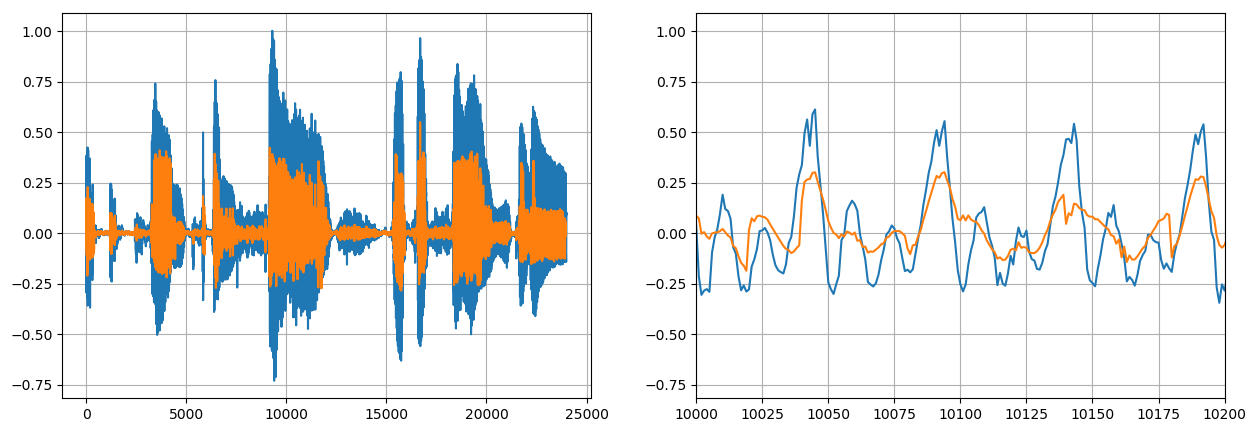

In [42]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(y_speech)
ax[1].plot(y_pred2)
ax[2].plot(y_speech)
ax[2].plot(y_pred2)
ax[1].grid(), ax[2].grid(), ax[2].set_xlim([10000, 10200])
audioplayers(y_speech, y_pred2, fs=fs_desired)

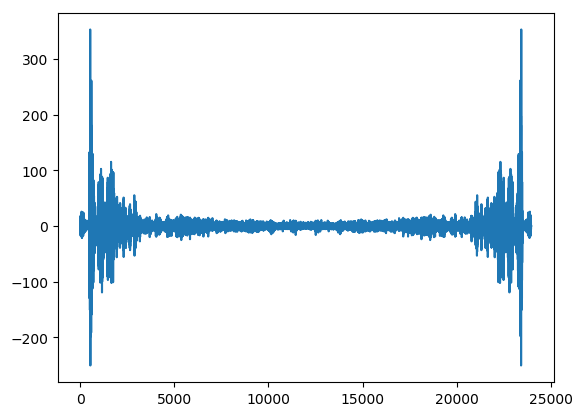

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000049E4828>

In [43]:
plt.plot(FFTW.fft(y_pred1))

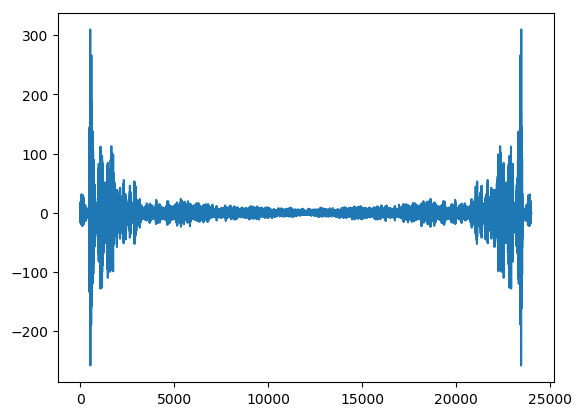

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000004A426A0>

In [44]:
plt.plot(FFTW.fft(y_speech))

In [33]:
f_speech

1198×40 Array{Complex{Float64},2}:
   0.217814+0.0im    0.273127-0.169922im    …    0.273127+0.169922im  
 -0.0523045+0.0im   -0.301453-0.0865371im       -0.301453+0.0865371im 
   0.257108+0.0im   -0.155738-0.117801im        -0.155738+0.117801im  
   0.634883+0.0im    0.343482+0.105061im         0.343482-0.105061im  
  0.0889419+0.0im   -0.099113+0.00507119im      -0.099113-0.00507119im
  -0.222984+0.0im    -0.41212+0.0995323im   …    -0.41212-0.0995323im 
  0.0540289+0.0im  -0.0687172-0.12246im        -0.0687172+0.12246im   
   0.249053+0.0im    0.119257+0.0418751im        0.119257-0.0418751im 
   -0.35285+0.0im   -0.417514+0.126974im        -0.417514-0.126974im  
  -0.114267+0.0im  -0.0992601-0.186713im       -0.0992601+0.186713im  
    0.13448+0.0im  -0.0957977-0.298996im    …  -0.0957977+0.298996im  
  -0.279636+0.0im   -0.535244+0.30582im         -0.535244-0.30582im   
    -0.1063+0.0im    0.127796+0.246202im         0.127796-0.246202im  
           ⋮                              

In [36]:
fft_expand(fft_reduce(f_speech))

1198×40 Array{Complex{Float64},2}:
   0.217814+0.0im    0.273127-0.169922im    …    0.273127+0.169922im  
 -0.0523045+0.0im   -0.301453-0.0865371im       -0.301453+0.0865371im 
   0.257108+0.0im   -0.155738-0.117801im        -0.155738+0.117801im  
   0.634883+0.0im    0.343482+0.105061im         0.343482-0.105061im  
  0.0889419+0.0im   -0.099113+0.00507119im      -0.099113-0.00507119im
  -0.222984+0.0im    -0.41212+0.0995323im   …    -0.41212-0.0995323im 
  0.0540289+0.0im  -0.0687172-0.12246im        -0.0687172+0.12246im   
   0.249053+0.0im    0.119257+0.0418751im        0.119257-0.0418751im 
   -0.35285+0.0im   -0.417514+0.126974im        -0.417514-0.126974im  
  -0.114267+0.0im  -0.0992601-0.186713im       -0.0992601+0.186713im  
    0.13448+0.0im  -0.0957977-0.298996im    …  -0.0957977+0.298996im  
  -0.279636+0.0im   -0.535244+0.30582im         -0.535244-0.30582im   
    -0.1063+0.0im    0.127796+0.246202im         0.127796-0.246202im  
           ⋮                              

In [37]:
f_speech[1,:]

40-element Array{Complex{Float64},1}:
  0.21781430117505252 + 0.0im                
   0.2731271550701892 - 0.1699216991466703im 
   0.2590984459489292 - 0.5469556535396034im 
 -0.14091272612000097 - 0.9777476350566843im 
  -0.9151288865511837 - 0.9894880774562966im 
  -1.5153278507349188 - 0.3042449521493684im 
  -1.3159974105614982 + 0.6419220862836393im 
  -0.4650423849360483 + 0.9613410672018029im 
  0.05200526495529428 + 0.46973742613100344im
  -0.1547562322462311 + 0.1329704419720686im 
   -0.135574200234008 + 0.2887635221969418im 
  0.05662528068021633 - 0.04098649795608439im
 -0.37593096878075233 - 0.08795907593311064im
                      ⋮                      
 -0.37593096878075216 + 0.0879590759331107im 
 0.056625280680216265 + 0.04098649795608454im
 -0.13557420023400799 - 0.2887635221969418im 
 -0.15475623224623114 - 0.13297044197206848im
  0.05200526495529428 - 0.46973742613100344im
  -0.4650423849360483 - 0.961341067201803im  
  -1.3159974105614984 - 0.6419220862836393

In [38]:
fft_expand(fft_reduce(f_speech))[1,:]

40-element Array{Complex{Float64},1}:
  0.21781430117505252 + 0.0im                
   0.2731271550701892 - 0.1699216991466703im 
   0.2590984459489292 - 0.5469556535396034im 
 -0.14091272612000097 - 0.9777476350566843im 
  -0.9151288865511837 - 0.9894880774562966im 
  -1.5153278507349188 - 0.3042449521493684im 
  -1.3159974105614982 + 0.6419220862836393im 
  -0.4650423849360483 + 0.9613410672018029im 
  0.05200526495529428 + 0.46973742613100344im
  -0.1547562322462311 + 0.1329704419720686im 
   -0.135574200234008 + 0.2887635221969418im 
  0.05662528068021633 - 0.04098649795608439im
 -0.37593096878075233 - 0.08795907593311064im
                      ⋮                      
 -0.37593096878075233 + 0.08795907593311064im
  0.05662528068021633 + 0.04098649795608439im
   -0.135574200234008 - 0.2887635221969418im 
  -0.1547562322462311 - 0.1329704419720686im 
  0.05200526495529428 - 0.46973742613100344im
  -0.4650423849360483 - 0.9613410672018029im 
  -1.3159974105614982 - 0.6419220862836393